# Preprocessing

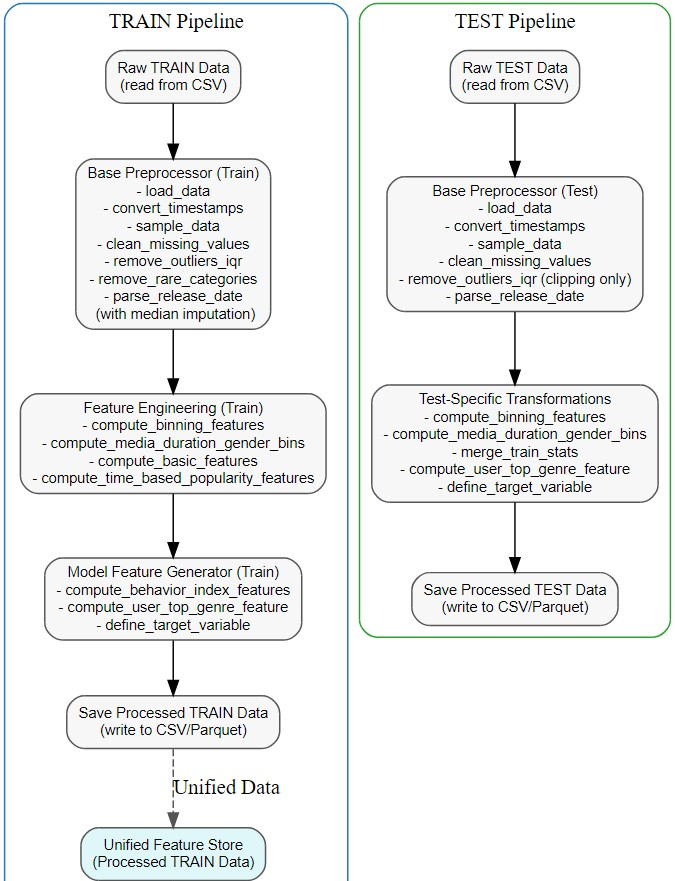

## Detailed Function Descriptions in Deezer**Train**Preprocessor

Below is an overview of each function implemented in the feature store generation script, reflecting the insights gained from our EDA and their implications for preprocessing.

1. **`load_data()`**  
   - **Purpose:** Efficiently loads the raw CSV data in manageable chunks using a defined `dtype_mapping` to optimize memory usage.
   - **Key Actions:**  
     - Mounts Google Drive (for Colab environments).
     - Reads the CSV file in chunks, concatenating them into a single DataFrame.
     - Ensures the `is_listened` column is filled (defaulting to 0) and cast to integer.

2. **`convert_timestamps()`**  
   - **Purpose:** Converts UNIX timestamps in `ts_listen` into datetime objects and extracts key time features.
   - **Key Actions:**  
     - Converts `ts_listen` using `pd.to_datetime` and drops invalid entries.
     - Filters the dataset to include only records from 2015 onward.
     - Derives additional temporal features such as `hour`, `weekday`, `is_weekend`, `day`, `week`, `month`, and `year`.

3. **`sample_data()`**  
   - **Purpose:** Subsamples the dataset to a specified fraction for faster experiments and resource management.
   - **Key Actions:**  
     - Randomly samples the data if the fraction is less than 1.0.
     - Uses a fixed random state for reproducibility.

4. **`clean_missing_values()`**  
   - **Purpose:** Handles missing or invalid values in the dataset to ensure consistency.
   - **Key Actions:**  
     - Imputes `user_age` with the median and clamps values to the range [10, 100].
     - Fills missing values in key categorical columns (e.g., `genre_id`, `user_id`) with `-1` and casts them to integers, since no missings are present nothing happens.

5. **`remove_outliers_iqr()`**  
   - **Purpose:** Removes outliers in specified numeric columns (e.g., `media_duration`) using the IQR method.
   - **Key Actions:**  
     - Calculates the 25th and 75th percentiles and defines lower and upper bounds based on 1.5 times the IQR.
     - Filters out records that fall outside these bounds, reducing the skew introduced by extreme values.

6. **`remove_rare_categories()`**  
   - **Purpose:** Reduces dimensionality by eliminating rarely occurring categories in specified columns.
   - **Key Actions:**  
     - Uses a fixed or auto-calculated threshold (based on quantiles) to drop infrequent categories.
     - Helps in managing heavy-tailed categorical distributions (e.g., `genre_id`).

7. **`parse_release_date()`**  
   - **Purpose:** Parses the `release_date` (provided as YYYYMMDD) into a datetime object and computes the age of the song.
   - **Key Actions:**  
     - Converts `release_date` to datetime using a custom parsing function.
     - Imputes missing `release_date_parsed` values with the median date.
     - Calculates `song_age_days` (the difference between `ts_listen` and the release date) and ensures non-negative values.

8. **`compute_binning_features()`**  
   - **Purpose:** Creates interpretable bins for numeric time features to capture high-level patterns.
   - **Key Actions:**  
     - Bins `hour` into periods like "Morning" or "Evening" (stored in `binTime`).
     - Categorizes `weekday` into "Weekend" or "Weekday" (`binwkd`).
     - Bins `year` into ranges (e.g., "Latest", "Oldies") via the `binRYear` column.

9. **`compute_media_duration_gender_bins()`**  
   - **Purpose:** Combines `media_duration` and `user_gender` into a single categorical feature (`md_mf_group`) to capture interactions between song length and gender.
   - **Key Actions:**  
     - Divides `media_duration` into intervals (e.g., ≤100, 101–200, etc.) and distinguishes by gender (0 or 1).
     - Assigns one of 11 possible group values based on these conditions.

10. **`compute_basic_features()`**  
    - **Purpose:** Computes fundamental aggregate features that describe listening behavior.
    - **Key Actions:**  
      - Calculates `avg_song_listened` (mean listening rate per song) and `avg_user_listened` (mean listening rate per user).
      - Computes `skip_score` as the ratio of skipped plays to total plays for each song.
      - Derives session-level metrics such as `avg_songs_per_session` and `avg_session_length` for each user.

11. **`compute_time_based_popularity_features()`**  
    - **Purpose:** Captures recent popularity trends by computing popularity metrics over different time windows (e.g., 7, 30, 90 days).
    - **Key Actions:**  
      - For each defined time window, filters the dataset to recent listens.
      - Computes popularity counts for songs, artists, and albums.
      - Merges these metrics back into the main DataFrame and fills missing values with zeros.

12. **`compute_behavior_index_features()`**  
    - **Purpose:** Derives a "behavior index" that quantifies a user’s affinity towards particular genres.
    - **Key Actions:**  
      - Computes the frequency of interactions (`genre_freq`) and the average listening ratio per user-genre pair.
      - Combines these using a formula (involving the square root and logarithm) to generate the `behavior_index`.

13. **`compute_user_top_genre_feature()`**  
    - **Purpose:** Determines each user’s most frequently listened genre.
    - **Key Actions:**  
      - Groups data by `user_id` and `genre_id` and identifies the genre with the highest count per user.
      - Maps this as the `user_top_genre` feature.

14. **`define_target_variable()`**  
    - **Purpose:** Finalizes the target variable for modeling.
    - **Key Actions:**  
      - Converts the `is_listened` column into a binary target (`target`), ensuring consistency for supervised learning tasks.

15. **`save_processed_data()`**  
    - **Purpose:** Exports the fully processed dataset and relevant training statistics for downstream analysis.
    - **Key Actions:**  
      - Saves the final DataFrame to disk in CSV or Parquet format.
      - Separately writes out aggregated statistics (e.g., `avg_song_listened`, `skip_score`, `behavior_index`) for potential use in model calibration.

16. **`run_pipeline()`**  
    - **Purpose:** Orchestrates all preprocessing steps in sequence to produce a final feature store.
    - **Key Actions:**  
      - Sequentially executes each function from data loading to target variable definition.
      - Invokes garbage collection between steps to manage memory.
      - Saves the processed data and related statistics to designated output paths.

This comprehensive preprocessing pipeline leverages our EDA insights—such as handling skewed distributions, managing outliers and rare categories, and engineering temporal and user-specific features—to create a robust feature store for subsequent recommendation model development.


In [ ]:
import os
import pandas as pd
import numpy as np
import gc
from datetime import datetime, timedelta
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# =============================================================================
# 1. DeezerTrainPreprocessor (TRAIN)
# =============================================================================
class DeezerTrainPreprocessor:
    """TRAIN preprocessor."""
    def __init__(self, file_path, frac_sampling=1.0, remove_outliers=True,
                 outlier_cols=["media_duration"], dimension_reduction=True,
                 drop_thresholds=None, compute_time_based_popularity=True,
                 compute_user_top_genre=True, use_behavior_index=True,
                 auto_threshold=False, quantile=0.05):
        """Init."""
        self.file_path = file_path
        self.frac_sampling = frac_sampling
        self.remove_outliers = remove_outliers
        self.outlier_cols = outlier_cols if outlier_cols else []
        self.dimension_reduction = dimension_reduction
        self.drop_thresholds = drop_thresholds if drop_thresholds else {}
        self.compute_time_based_popularity = compute_time_based_popularity
        self.compute_user_top_genre = compute_user_top_genre  # Bool, ob top-genre berechnet werden soll
        self.use_behavior_index = use_behavior_index
        self.auto_threshold = auto_threshold
        self.quantile = quantile

        self.data = None
        self.is_train = True
        self.train_stats = {}

    def clean_memory(self):
        """Garbage collect."""
        gc.collect()

    def load_data(self):
        """Load data."""
        drive.mount('/content/drive', force_remount=True)
        dtype_mapping = {
            'genre_id': 'int32', 'ts_listen': 'int64', 'media_id': 'int32',
            'album_id': 'int32', 'context_type': 'int8', 'release_date': 'int32',
            'platform_name': 'int8', 'platform_family': 'int8', 'media_duration': 'int16',
            'listen_type': 'int8', 'user_gender': 'int8', 'user_id': 'int32',
            'artist_id': 'int32', 'user_age': 'int8', 'is_listened': 'int8'
        }
        chunks = []
        chunk_size = 100000
        for chunk in pd.read_csv(self.file_path, dtype=dtype_mapping, chunksize=chunk_size):
            chunks.append(chunk)
        self.data = pd.concat(chunks, ignore_index=True)
        del chunks
        self.data['is_listened'] = self.data['is_listened'].fillna(0).astype(int)
        print("[TRAIN] Data loaded. Shape:", self.data.shape)

    def convert_timestamps(self):
        """Convert timestamps."""
        self.data['ts_listen'] = pd.to_datetime(self.data['ts_listen'], unit='s', errors='coerce')
        self.data.dropna(subset=['ts_listen'], inplace=True)
        # Filter: Nur Daten ab 2015
        self.data = self.data[self.data['ts_listen'].dt.year >= 2015]
        self.data['hour'] = self.data['ts_listen'].dt.hour
        self.data['weekday'] = self.data['ts_listen'].dt.weekday
        self.data['is_weekend'] = self.data['weekday'].isin([5,6]).astype(int)
        self.data['day'] = self.data['ts_listen'].dt.day
        self.data['week'] = self.data['ts_listen'].dt.isocalendar().week.astype(int)
        self.data['month'] = self.data['ts_listen'].dt.month
        self.data['year'] = self.data['ts_listen'].dt.year
        print("[TRAIN] Timestamps converted and filtered.")

    def sample_data(self):
        """Subsample data."""
        if self.frac_sampling < 1.0:
            orig_len = len(self.data)
            self.data = self.data.sample(frac=self.frac_sampling, random_state=42).reset_index(drop=True)
            print(f"[TRAIN] Subsampling: {len(self.data)} rows ({self.frac_sampling*100:.1f}% of {orig_len}).")

    def clean_missing_values(self):
        """Fill missing values."""
        self.data['user_gender'] = self.data['user_gender'].fillna(-1)
        median_age = self.data['user_age'].median()
        self.data['user_age'] = self.data['user_age'].fillna(median_age)
        self.data.loc[self.data['user_age'] < 10, 'user_age'] = 10
        self.data.loc[self.data['user_age'] > 100, 'user_age'] = 100
        for col in ['genre_id', 'user_id', 'artist_id', 'album_id', 'media_id']:
            if col in self.data.columns:
                self.data[col] = self.data[col].fillna(-1).astype(int)
        print("[TRAIN] Missing values handled.")

    def remove_outliers_iqr(self):
        """Remove outliers using IQR."""
        if not self.remove_outliers:
            return
        for col in self.outlier_cols:
            if col not in self.data.columns:
                print(f"[TRAIN:WARN] Column {col} not found.")
                continue
            Q1 = self.data[col].quantile(0.25)
            Q3 = self.data[col].quantile(0.75)
            iqr = Q3 - Q1
            lower_bound = Q1 - 1.5 * iqr
            upper_bound = Q3 + 1.5 * iqr
            orig_len = len(self.data)
            self.data = self.data[(self.data[col] >= lower_bound) & (self.data[col] <= upper_bound)]
            new_len = len(self.data)
            print(f"[TRAIN] {col} outliers removed: {orig_len-new_len} rows.")

    def remove_rare_categories(self):
        """Remove rare categories."""
        if not self.dimension_reduction or not self.drop_thresholds:
            return
        for col in self.drop_thresholds.keys():
            if col not in self.data.columns:
                print(f"[TRAIN:WARN] '{col}' not found.")
                continue
            counts = self.data[col].value_counts()
            if self.auto_threshold:
                threshold = int(counts.quantile(self.quantile))
                print(f"[TRAIN] Auto-threshold for {col} set to {threshold}.")
            else:
                threshold = self.drop_thresholds[col]
            orig_len = len(self.data)
            self.data = self.data[~self.data[col].isin(counts[counts < threshold].index)]
            new_len = len(self.data)
            print(f"[TRAIN] Rare categories in {col} removed: {orig_len-new_len} rows.")

    def parse_release_date(self):
        """Parse the release date, compute song_age_days, and impute missing release_date_parsed with the median date."""
        if 'release_date' not in self.data.columns:
            print("[TRAIN:WARN] release_date missing.")
            return
        def parse_ymd(date_int):
            date_str = str(date_int)
            try:
                return datetime(int(date_str[:4]), int(date_str[4:6]), int(date_str[6:8]))
            except:
                return None
        self.data['release_date_parsed'] = self.data['release_date'].apply(parse_ymd)
        self.data['release_date_parsed'] = pd.to_datetime(self.data['release_date_parsed'], errors='coerce')
        # Perform median imputation for missing dates
        if self.data['release_date_parsed'].isnull().any():
            median_date = self.data['release_date_parsed'].median()
            self.data['release_date_parsed'] = self.data['release_date_parsed'].fillna(median_date)
            print(f"[TRAIN] Missing release_date_parsed imputed with median date: {median_date}.")

        # Calculate the song age in days using the (now imputed) release date
        self.data['song_age_days'] = (self.data['ts_listen'] - self.data['release_date_parsed']).dt.days
        self.data['song_age_days'] = self.data['song_age_days'].fillna(0)
        self.data.loc[self.data['song_age_days'] < 0, 'song_age_days'] = 0
        self.data.drop(columns=['release_date'], inplace=True)
        print("[TRAIN] Release date parsed and missing values imputed with median date.")


    def compute_binning_features(self):
        """Compute binning features."""
        def bin_time(h):
            if 0 <= h <= 3: return "Midnight"
            elif 4 <= h <= 5: return "EarlyMorning"
            elif 6 <= h <= 8: return "MidMorning"
            elif 9 <= h <= 11: return "Morning"
            elif 12 <= h <= 16: return "Noon"
            elif 17 <= h <= 20: return "Evening"
            else: return "Night"
        if 'hour' in self.data.columns:
            self.data['binTime'] = self.data['hour'].apply(bin_time)
        if 'weekday' in self.data.columns:
            self.data['binwkd'] = self.data['weekday'].apply(lambda wd: "Weekend" if wd in [5,6] else "Weekday")
        if 'year' in self.data.columns:
            def bin_year(y):
                if y > 2017: return "Outliers"
                elif y == 2017: return "Recents"
                elif 2015 <= y <= 2016: return "Latest"
                elif 2010 <= y <= 2014: return "FairlyLatest"
                elif 2000 <= y <= 2009: return "Mids1"
                elif 1990 <= y <= 1999: return "Mids2"
                elif 1980 <= y <= 1989: return "Oldies1"
                elif 1970 <= y <= 1979: return "Oldies2"
                elif 1950 <= y <= 1969: return "Oldies3"
                else: return "VeryOld"
            self.data['binRYear'] = self.data['year'].apply(bin_year)
        print("[TRAIN] Binning features computed.")

    def compute_media_duration_gender_bins(self):
        """Compute media duration & gender bins."""
        if 'media_duration' not in self.data.columns or 'user_gender' not in self.data.columns:
            print("[TRAIN:WARN] media_duration or user_gender missing.")
            return
        def get_md_mf_group(mdur, ug):
            if mdur <= 100 and ug == 0: return 1
            elif mdur <= 100 and ug == 1: return 2
            elif 101 <= mdur <= 200 and ug == 0: return 3
            elif 101 <= mdur <= 200 and ug == 1: return 4
            elif 201 <= mdur <= 300 and ug == 0: return 5
            elif 201 <= mdur <= 300 and ug == 1: return 6
            elif 301 <= mdur <= 400 and ug == 0: return 7
            elif 301 <= mdur <= 400 and ug == 1: return 8
            elif 401 <= mdur <= 500 and ug == 0: return 9
            elif 401 <= mdur <= 500 and ug == 1: return 10
            else: return 11
        self.data['md_mf_group'] = self.data.apply(lambda row: get_md_mf_group(row['media_duration'], row['user_gender']), axis=1)
        print("[TRAIN] md_mf_group computed.")

    def compute_basic_features(self):
        """Compute basic features."""
        self.data['avg_song_listened'] = self.data.groupby('media_id')['is_listened'].transform('mean')
        self.data['avg_user_listened'] = self.data.groupby('user_id')['is_listened'].transform('mean')
        total_listens = self.data.groupby('media_id')['is_listened'].transform('count')
        sum_listens = self.data.groupby('media_id')['is_listened'].transform('sum')
        skips = total_listens - sum_listens
        self.data['skip_score'] = skips / total_listens
        self.data['avg_songs_per_session'] = self.data.groupby('user_id')['media_id'].transform('count')
        self.data['avg_session_length'] = self.data.groupby('user_id')['media_duration'].transform('sum')
        print("[TRAIN] Basic features computed.")

    def compute_time_based_popularity_features(self, days_list=[7,30,90]):
        """Compute time-based popularity features."""
        max_ts = self.data['ts_listen'].max()
        for days in days_list:
            cutoff = max_ts - timedelta(days=days)
            recent = self.data[self.data['ts_listen'] >= cutoff]
            song_counts = recent['media_id'].value_counts().rename_axis('media_id').reset_index(name=f'{days}d_song_popularity')
            artist_counts = recent['artist_id'].value_counts().rename_axis('artist_id').reset_index(name=f'{days}d_artist_popularity')
            if 'album_id' in self.data.columns:
                album_counts = recent['album_id'].value_counts().rename_axis('album_id').reset_index(name=f'{days}d_album_popularity')
            else:
                album_counts = pd.DataFrame(columns=['album_id', f'{days}d_album_popularity'])
            self.data = self.data.merge(song_counts, on='media_id', how='left')
            self.data = self.data.merge(artist_counts, on='artist_id', how='left')
            if 'album_id' in self.data.columns and not album_counts.empty:
                self.data = self.data.merge(album_counts, on='album_id', how='left')
            for col in [f'{days}d_song_popularity', f'{days}d_artist_popularity', f'{days}d_album_popularity']:
                if col in self.data.columns:
                    self.data[col] = self.data[col].fillna(0)
            print(f"[TRAIN] Popularity for last {days} days computed.")

    def compute_behavior_index_features(self):
        """Compute behavior index feature."""
        if 'genre_id' not in self.data.columns:
            print("[TRAIN:WARN] 'genre_id' missing.")
            return
        freq_df = self.data.groupby(['user_id','genre_id']).size().reset_index(name='count_uc')
        listen_df = self.data.groupby(['user_id','genre_id'])['is_listened'].mean().reset_index(name='listen_ratio')
        sum_user = freq_df.groupby('user_id')['count_uc'].transform('sum')
        freq_df['genre_freq'] = freq_df['count_uc'] / sum_user
        tmp = pd.merge(freq_df, listen_df, on=['user_id','genre_id'], how='left')
        tmp['behavior_index'] = np.sqrt(tmp['genre_freq']) * tmp['listen_ratio'] * np.log(tmp['count_uc']+1)
        self.data = pd.merge(self.data, tmp[['user_id','genre_id','behavior_index']], on=['user_id','genre_id'], how='left')
        self.data['behavior_index'] = self.data['behavior_index'].fillna(0)
        print("[TRAIN] Behavior index computed.")

    def compute_user_top_genre_feature(self):
        """Compute user top genre feature."""
        if 'genre_id' not in self.data.columns:
            print("[TRAIN:WARN] 'genre_id' missing.")
            return
        grouped = self.data.groupby(['user_id','genre_id']).size()
        user_fav = grouped.groupby(level=0).idxmax().apply(lambda x: x[1])
        self.data['user_top_genre'] = self.data['user_id'].map(user_fav).fillna(-1).astype(int)
        print("[TRAIN] user_top_genre computed.")

    def define_target_variable(self):
        """Define target variable."""
        self.data['target'] = self.data['is_listened'].astype(int)
        print("[TRAIN] Target variable defined.")

    def save_processed_data(self, output_path="processed_deezer_train", file_format="parquet"):
        """Save processed data."""
        base_path = f"/content/drive/MyDrive/Colab Notebooks/{output_path}"
        if file_format.lower() == "parquet":
            path_parquet = base_path + ".parquet"
            self.data.to_parquet(path_parquet, index=False)
            print(f"[TRAIN] Data saved: {path_parquet}")
        elif file_format.lower() == "csv":
            path_csv = base_path + ".csv"
            self.data.to_csv(path_csv, index=False)
            print(f"[TRAIN] Data saved: {path_csv}")
        else:
            path_csv = base_path + ".csv"
            self.data.to_csv(path_csv, index=False)
            print(f"[TRAIN:WARN] Unknown format, saved as CSV: {path_csv}")
        # Save train stats
        song_avg_listen = self.data.groupby('media_id')['avg_song_listened'].first().fillna(0)
        skip_score_map = self.data.groupby('media_id')['skip_score'].first().fillna(0)
        if 'behavior_index' in self.data.columns:
            behavior_map = self.data.groupby(['user_id','genre_id'])['behavior_index'].first()
        else:
            behavior_map = pd.Series(dtype='float64')
        song_avg_listen.to_csv(f"/content/drive/MyDrive/Colab Notebooks/train_stats_song_avg_listen.csv", header=True)
        skip_score_map.to_csv(f"/content/drive/MyDrive/Colab Notebooks/train_stats_skip_score.csv", header=True)
        behavior_map.to_csv(f"/content/drive/MyDrive/Colab Notebooks/train_stats_behavior_index.csv", header=True)
        print("[TRAIN] Train statistics saved.")

    def run_pipeline(self, output_format="parquet"):
        """Run all preprocessing steps."""
        self.load_data(); self.clean_memory()
        self.convert_timestamps(); self.clean_memory()
        self.sample_data(); self.clean_memory()
        self.clean_missing_values(); self.clean_memory()
        self.remove_outliers_iqr(); self.clean_memory()
        self.remove_rare_categories(); self.clean_memory()
        self.parse_release_date(); self.clean_memory()
        self.compute_binning_features(); self.clean_memory()
        self.compute_media_duration_gender_bins(); self.clean_memory()
        self.compute_basic_features(); self.clean_memory()
        if self.compute_time_based_popularity:
            self.compute_time_based_popularity_features(); self.clean_memory()
        if self.use_behavior_index:
            self.compute_behavior_index_features(); self.clean_memory()
        if self.compute_user_top_genre:
            self.compute_user_top_genre_feature(); self.clean_memory()
        self.define_target_variable(); self.clean_memory()
        self.save_processed_data("processed_deezer_train", file_format=output_format)
        self.clean_memory()

> ### Training Pipeline Overview  
>
> The training pipeline implemented in **`DeezerTrainPreprocessor`** is designed to transform our raw dataset into a robust feature store tailored for recommendation modeling.
>
> Building on our **EDA** conclusions—which confirmed the absence of missing values and duplicates, and highlighted the need to focus on data from **2015 onward**—we filter out older records and extract rich time-based features (e.g., **hour**, **weekday**, etc.).
>
> Recognizing the **right-skew** in **`media_duration`** (with extreme values up to **65,535 seconds**), we employ **IQR-based outlier removal** to mitigate the influence of these extremes.
>
> Additionally, given the **heavy-tailed distributions** observed in categorical features like **`genre_id`**, **`media_id`**, **`album_id`**, and **`artist_id`**, we leverage **dimension reduction** via frequency thresholds (with an auto-calculated **5% quantile threshold** for **`genre_id`**) to manage rarely occurring categories.
>
> The pipeline also computes **time-based popularity features** over **7-, 30-, and 90-day windows**, and derives **user-specific metrics** such as the **behavior index** and each user’s **top genre**, capturing nuanced listening patterns.
>
> Configured to sample **100% of the data** and enable all these preprocessing steps, the pipeline ultimately saves the enriched dataset in **CSV format**—providing a clean, representative foundation for robust recommendation system development.


In [ ]:
# =============================================================================
# Invocation (TRAIN)
# =============================================================================
if __name__ == "__main__":
    # TRAIN Pipeline
    # Define the file path for the training dataset.
    train_path = "/content/drive/MyDrive/Colab Notebooks/train.csv"

    # Initialize the training preprocessor with the desired parameters.
    train_preprocessor = DeezerTrainPreprocessor(
        file_path=train_path,                      # Path to the training CSV file.
        frac_sampling=1.0,                         # Use 100% of the training data (no subsampling).
        remove_outliers=True,                      # Enable outlier removal.
        outlier_cols=["media_duration"],           # Specify which column(s) to use for outlier removal.
        dimension_reduction=True,                  # Enable dimension reduction (removal of rare categories).
        drop_thresholds={"genre_id": 50},          # Set the threshold for removing rare categories (or auto-calculate if True).
        compute_time_based_popularity=True,        # Compute time-based popularity features.
        compute_user_top_genre=True,               # Compute the top genre for each user.
        use_behavior_index=True,                   # Compute behavior index features.
        auto_threshold=True,                       # Enable automatic threshold calculation using a quantile.
        quantile=0.05                              # Use the 5% quantile to calculate the threshold if auto_threshold is True.
    )

    # Run the complete training preprocessing pipeline.
    # This will perform all transformations and save the processed training data in CSV format.
    train_preprocessor.run_pipeline(output_format="csv")

    # Print a confirmation message indicating that the training pipeline has completed.
    print("[TRAIN] Pipeline completed.")


Mounted at /content/drive
[TRAIN] Data loaded. Shape: (7558834, 15)
[TRAIN] Timestamps converted and filtered.
[TRAIN] Missing values handled.
[TRAIN] media_duration outliers removed: 406105 rows.
[TRAIN] Auto-threshold for genre_id set to 1.
[TRAIN] Rare categories in genre_id removed: 0 rows.
[TRAIN] Missing release_date_parsed imputed with median date: 2014-12-09 00:00:00.
[TRAIN] Release date parsed and missing values imputed with median date.
[TRAIN] Binning features computed.
[TRAIN] md_mf_group computed.
[TRAIN] Basic features computed.
[TRAIN] Popularity for last 7 days computed.
[TRAIN] Popularity for last 30 days computed.
[TRAIN] Popularity for last 90 days computed.
[TRAIN] Behavior index computed.
[TRAIN] user_top_genre computed.
[TRAIN] Target variable defined.
[TRAIN] Data saved: /content/drive/MyDrive/Colab Notebooks/processed_deezer_train.csv
[TRAIN] Train statistics saved.
[TRAIN] Pipeline completed.


## Detailed Function Descriptions in Deezer**Test**Preprocessor

Below is an overview of each function in the test preprocessor, which is tailored to enrich the test data with features computed from the training set while preserving the test data’s integrity:

1. **`load_data()`**  
   - **Purpose:** Loads the raw test data efficiently in chunks using a memory-optimized dtype mapping.
   - **Key Actions:**  
     - Mounts Google Drive (for Colab usage).
     - Reads CSV data in chunks and concatenates them into a single DataFrame.
     - Ensures the test data is loaded with the correct dtypes.

2. **`sample_data()`**  
   - **Purpose:** Subsamples the test data to a specified fraction, facilitating faster experiments.
   - **Key Actions:**  
     - Randomly samples the data if the fraction is less than 1.0, using a fixed random seed for reproducibility.

3. **`clean_missing_values()`**  
   - **Purpose:** Handles missing values in the test dataset to maintain consistency.
   - **Key Actions:**  
     - Imputes `user_age` with its median value and clamps ages to the range [10, 100].
     - Fills missing values for key categorical columns (e.g., `genre_id`, `user_id`, `artist_id`, `album_id`, `media_id`) with `-1`.

4. **`remove_outliers_iqr()`**  
   - **Purpose:**  
     Applies outlier clipping on `media_duration` if enabled, without removing rows.
   - **Key Actions:**  
     - Uses `np.clip` to constrain `media_duration` values between 10 and 800, mitigating the influence of extreme values.

5. **`remove_rare_categories()`** and **`drop_rare_genres()`**  
   - **Purpose:** (Intentionally skipped for test data)  
     These functions are placeholders and are not applied to test data.

6. **`convert_timestamps()`**  
   - **Purpose:** Converts UNIX timestamps (`ts_listen`) into datetime objects and extracts temporal features.
   - **Key Actions:**  
     - Converts `ts_listen` using `pd.to_datetime` and drops invalid entries.
     - Derives additional time-based features such as `hour`, `weekday`, `is_weekend`, `day`, `week`, `month`, and `year`.

7. **`parse_release_date()`**  
   - **Purpose:** Parses the `release_date` into a datetime format and computes `song_age_days` for test data.
   - **Key Actions:**  
     - Converts the `YYYYMMDD` formatted `release_date` using a custom parser.
     - Computes `song_age_days` (the difference between `ts_listen` and the parsed release date), ensuring no negative values.
     - Drops the original `release_date` column.

8. **`compute_binning_features()`**  
   - **Purpose:** Generates binned versions of numeric time features to provide interpretable categorical variables.
   - **Key Actions:**  
     - Creates `binTime` from `hour`, `binwkd` from `weekday`, and `binRYear` from `year` to capture time-of-day and era patterns.

9. **`compute_media_duration_gender_bins()`**  
   - **Purpose:** Produces a combined categorical feature (`md_mf_group`) based on `media_duration` and `user_gender`.
   - **Key Actions:**  
     - Bins `media_duration` into intervals (e.g., ≤100, 101–200, etc.) and distinguishes based on gender (0 or 1), resulting in 11 possible groups.

10. **`merge_train_stats()`**  
    - **Purpose:** Integrates aggregated training statistics (e.g., `avg_song_listened`, `skip_score`, and optionally `behavior_index`) into the test dataset.
    - **Key Actions:**  
      - Reads training statistics CSV files.
      - Merges these statistics into the test data based on `media_id` (and `user_id`/`genre_id` for behavior index).
      - Fills missing values with defaults (typically zero).

11. **`compute_user_top_genre_feature()`**  
    - **Purpose:** Determines the most frequently listened genre for each user in the test dataset.
    - **Key Actions:**  
      - Groups the test data by `user_id` and `genre_id` to calculate genre frequencies.
      - Assigns the most frequent genre as the `user_top_genre` for each user.

12. **`define_target_variable()`**  
    - **Purpose:** Defines the target variable (`target`) in the test data, if available.
    - **Key Actions:**  
      - Converts `is_listened` (if present) to an integer binary target.
      - Provides a notification if the target is missing.

13. **`save_processed_data()`**  
    - **Purpose:** Saves the enriched test dataset to disk in the specified format (CSV or Parquet).
    - **Key Actions:**  
      - Exports the final DataFrame and confirms the save location via printed messages.

14. **`run_pipeline()`**  
    - **Purpose:** Orchestrates the entire preprocessing pipeline for test data.
    - **Key Actions:**  
      - Sequentially executes functions to load, clean, and enrich the test dataset.
      - Skips outlier removal and rare category filtering (as per test configuration).
      - Merges in training statistics when provided.
      - Saves the final processed test data and performs garbage collection between steps.

This pipeline ensures that the test data is preprocessed consistently with the training data, incorporating key temporal, user-level, and behavior-based features, while preserving all categories to enable robust evaluation and recommendation model development.


In [ ]:
# =============================================================================
# 2. DeezerTestPreprocessor (TEST)
# =============================================================================
class DeezerTestPreprocessor:
    """TEST preprocessor."""
    def __init__(self, file_path, frac_sampling=1.0, apply_outliers=True,
                 outlier_cols=["media_duration"], dimension_reduction=True,
                 drop_thresholds=None, compute_time_based_popularity=False,
                 compute_user_top_genre=True, use_behavior_index=True,
                 auto_threshold=False, quantile=0.05):
        """Initialize the test preprocessor."""
        self.file_path = file_path
        self.frac_sampling = frac_sampling
        self.apply_outliers = apply_outliers
        self.outlier_cols = outlier_cols if outlier_cols else []
        self.dimension_reduction = dimension_reduction
        self.drop_thresholds = drop_thresholds if drop_thresholds else {}
        self.compute_time_based_popularity = compute_time_based_popularity
        self.compute_user_top_genre = compute_user_top_genre  # Boolean
        self.use_behavior_index = use_behavior_index
        self.auto_threshold = auto_threshold
        self.quantile = quantile

        self.data = None
        self.is_train = False

    def clean_memory(self):
        """Perform garbage collection."""
        gc.collect()

    def load_data(self):
        """Load test data."""
        drive.mount('/content/drive', force_remount=True)
        dtype_mapping = {
            'sample_id': 'int32', 'genre_id': 'int32', 'ts_listen': 'int64', 'media_id': 'int32',
            'album_id': 'int32', 'context_type': 'int8', 'release_date': 'int32',
            'platform_name': 'int8', 'platform_family': 'int8', 'media_duration': 'int16',
            'listen_type': 'int8', 'user_gender': 'int8', 'user_id': 'int32',
            'artist_id': 'int32', 'user_age': 'int8'
        }
        chunks = []
        chunk_size = 100000
        for chunk in pd.read_csv(self.file_path, dtype=dtype_mapping, chunksize=chunk_size):
            chunks.append(chunk)
        self.data = pd.concat(chunks, ignore_index=True)
        del chunks
        print("[TEST] Data loaded. Shape:", self.data.shape)

    def sample_data(self):
        """Subsample test data if required."""
        if self.frac_sampling < 1.0:
            orig_len = len(self.data)
            self.data = self.data.sample(frac=self.frac_sampling, random_state=42).reset_index(drop=True)
            print(f"[TEST] Subsampling: {len(self.data)} rows ({self.frac_sampling*100:.1f}% of {orig_len}).")

    def clean_missing_values(self):
        """Fill missing values for test data."""
        self.data['user_gender'] = self.data['user_gender'].fillna(-1)
        median_age = self.data['user_age'].median()
        self.data['user_age'] = self.data['user_age'].fillna(median_age)
        self.data.loc[self.data['user_age'] < 10, 'user_age'] = 10
        self.data.loc[self.data['user_age'] > 100, 'user_age'] = 100
        for col in ['genre_id','user_id','artist_id','album_id','media_id']:
            if col in self.data.columns:
                self.data[col] = self.data[col].fillna(-1).astype(int)
        print("[TEST] Missing values handled.")

    def remove_outliers_iqr(self):
        """Clip outliers in test data (if enabled)."""
        if not self.apply_outliers:
            return
        col = "media_duration"
        if col in self.data.columns:
            self.data[col] = np.clip(self.data[col], 10, 800)
            print("[TEST] Outlier clipping applied.")
        else:
            print("[TEST:WARN] media_duration missing.")

    def remove_rare_categories(self):
        """(Not used in TEST) Do not remove rare categories from test data."""
        pass

    def drop_rare_genres(self, allowed_genres):
        """(Not used in TEST) Do not drop any genres in test data."""
        pass

    def convert_timestamps(self):
        """Convert timestamps in test data."""
        self.data['ts_listen'] = pd.to_datetime(self.data['ts_listen'], unit='s', errors='coerce')
        self.data.dropna(subset=['ts_listen'], inplace=True)
        self.data['hour'] = self.data['ts_listen'].dt.hour
        self.data['weekday'] = self.data['ts_listen'].dt.weekday
        self.data['is_weekend'] = self.data['ts_listen'].dt.weekday.isin([5,6]).astype(int)
        self.data['day'] = self.data['ts_listen'].dt.day
        self.data['week'] = self.data['ts_listen'].dt.isocalendar().week.astype(int)
        self.data['month'] = self.data['ts_listen'].dt.month
        self.data['year'] = self.data['ts_listen'].dt.year
        print("[TEST] Timestamps converted.")

    def parse_release_date(self):
        """Parse release date in test data."""
        if 'release_date' not in self.data.columns:
            print("[TEST:WARN] release_date missing.")
            return
        def parse_ymd(date_int):
            date_str = str(date_int)
            try:
                return datetime(int(date_str[:4]), int(date_str[4:6]), int(date_str[6:8]))
            except:
                return None
        self.data['release_date_parsed'] = self.data['release_date'].apply(parse_ymd)
        self.data['release_date_parsed'] = pd.to_datetime(self.data['release_date_parsed'], errors='coerce')
        self.data['song_age_days'] = (self.data['ts_listen'] - self.data['release_date_parsed']).dt.days
        self.data['song_age_days'] = self.data['song_age_days'].fillna(0)
        self.data.loc[self.data['song_age_days'] < 0, 'song_age_days'] = 0
        self.data.drop(columns=['release_date'], inplace=True)
        print("[TEST] Release date parsed.")

    def compute_binning_features(self):
        """Compute binning features in test data."""
        def bin_time(h):
            if 0 <= h <= 3: return "Midnight"
            elif 4 <= h <= 5: return "EarlyMorning"
            elif 6 <= h <= 8: return "MidMorning"
            elif 9 <= h <= 11: return "Morning"
            elif 12 <= h <= 16: return "Noon"
            elif 17 <= h <= 20: return "Evening"
            else: return "Night"
        if 'hour' in self.data.columns:
            self.data['binTime'] = self.data['hour'].apply(bin_time)
        if 'weekday' in self.data.columns:
            self.data['binwkd'] = self.data['weekday'].apply(lambda wd: "Weekend" if wd in [5,6] else "Weekday")
        if 'year' in self.data.columns:
            def bin_year(y):
                if y > 2017: return "Outliers"
                elif y == 2017: return "Recents"
                elif 2015 <= y <= 2016: return "Latest"
                elif 2010 <= y <= 2014: return "FairlyLatest"
                elif 2000 <= y <= 2009: return "Mids1"
                elif 1990 <= y <= 1999: return "Mids2"
                elif 1980 <= y <= 1989: return "Oldies1"
                elif 1970 <= y <= 1979: return "Oldies2"
                elif 1950 <= y <= 1969: return "Oldies3"
                else: return "VeryOld"
            self.data['binRYear'] = self.data['year'].apply(bin_year)
        print("[TEST] Binning features computed.")

    def compute_media_duration_gender_bins(self):
        """Compute media duration & gender groups in test data."""
        if 'media_duration' not in self.data.columns or 'user_gender' not in self.data.columns:
            print("[TEST:WARN] media_duration or user_gender missing.")
            return
        def get_md_mf_group(mdur, ug):
            if mdur <= 100 and ug == 0: return 1
            elif mdur <= 100 and ug == 1: return 2
            elif 101 <= mdur <= 200 and ug == 0: return 3
            elif 101 <= mdur <= 200 and ug == 1: return 4
            elif 201 <= mdur <= 300 and ug == 0: return 5
            elif 201 <= mdur <= 300 and ug == 1: return 6
            elif 301 <= mdur <= 400 and ug == 0: return 7
            elif 301 <= mdur <= 400 and ug == 1: return 8
            elif 401 <= mdur <= 500 and ug == 0: return 9
            elif 401 <= mdur <= 500 and ug == 1: return 10
            else: return 11
        self.data['md_mf_group'] = self.data.apply(lambda row: get_md_mf_group(row['media_duration'], row['user_gender']), axis=1)
        print("[TEST] md_mf_group computed.")

    def merge_train_stats(self, path_song_avg_listen, path_skip_score, path_behavior_index=None):
        """Merge training statistics into test data."""
        song_avg_df = pd.read_csv(path_song_avg_listen, index_col=0, header=0)
        if song_avg_df.columns.tolist() == ['0']:
            song_avg_df.rename(columns={'0': 'avg_song_listened'}, inplace=True)
        song_avg_df.reset_index(inplace=True)
        song_avg_df.rename(columns={'index': 'media_id'}, inplace=True)
        self.data = self.data.merge(song_avg_df, on='media_id', how='left')
        self.data['avg_song_listened'] = self.data['avg_song_listened'].fillna(0)
        skip_score_df = pd.read_csv(path_skip_score, index_col=0, header=0)
        if skip_score_df.columns.tolist() == ['0']:
            skip_score_df.rename(columns={'0': 'skip_score'}, inplace=True)
        skip_score_df.reset_index(inplace=True)
        skip_score_df.rename(columns={'index': 'media_id'}, inplace=True)
        self.data = self.data.merge(skip_score_df, on='media_id', how='left')
        self.data['skip_score'] = self.data['skip_score'].fillna(0)
        if path_behavior_index is not None:
            behav_df = pd.read_csv(path_behavior_index, header=0)
            behav_df.rename(columns={behav_df.columns[0]: 'user_id',
                                     behav_df.columns[1]: 'genre_id',
                                     behav_df.columns[2]: 'behavior_index'}, inplace=True)
            self.data = pd.merge(self.data, behav_df, on=['user_id','genre_id'], how='left')
            self.data['behavior_index'] = self.data['behavior_index'].fillna(0)
        else:
            self.data['behavior_index'] = 0.0
        print("[TEST] Train stats merged.")

    def compute_user_top_genre_feature(self):
        """Compute user top genre for test data."""
        if 'genre_id' not in self.data.columns:
            print("[TEST:WARN] 'genre_id' missing. Cannot compute user_top_genre.")
            return
        grouped = self.data.groupby(['user_id','genre_id']).size()
        user_fav = grouped.groupby(level=0).idxmax().apply(lambda x: x[1])
        self.data['user_top_genre'] = self.data['user_id'].map(user_fav).fillna(-1).astype(int)
        print("[TEST] user_top_genre computed.")

    def define_target_variable(self):
        """Define target variable in test data."""
        if 'is_listened' in self.data.columns:
            self.data['target'] = self.data['is_listened'].astype(int)
            print("[TEST] Target variable defined.")
        else:
            print("[TEST] 'is_listened' missing; target not defined.")

    def save_processed_data(self, output_path="processed_deezer_test", file_format="parquet"):
        """Save processed test data."""
        base_path = f"/content/drive/MyDrive/Colab Notebooks/{output_path}"
        if file_format.lower() == "parquet":
            path_parquet = base_path + ".parquet"
            self.data.to_parquet(path_parquet, index=False)
            print(f"[TEST] Data saved: {path_parquet}")
        elif file_format.lower() == "csv":
            path_csv = base_path + ".csv"
            self.data.to_csv(path_csv, index=False)
            print(f"[TEST] Data saved: {path_csv}")
        else:
            path_csv = base_path + ".csv"
            self.data.to_csv(path_csv, index=False)
            print(f"[TEST:WARN] Unknown format, saved as CSV: {path_csv}")

    def run_pipeline(self, train_allowed_genres=None, path_song_avg_listen=None,
                     path_skip_score=None, path_behavior_index=None, path_user_top_genre=None,
                     output_format="parquet"):
        """Run the complete test preprocessing pipeline.

        Note: For test data, outlier removal and rare category filtering are skipped.
        """
        self.load_data(); self.clean_memory()
        self.convert_timestamps(); self.clean_memory()
        self.sample_data(); self.clean_memory()
        self.clean_missing_values(); self.clean_memory()
        # Skip outlier and rare category removal for test data:
        # self.remove_outliers_iqr() and self.remove_rare_categories() are intentionally omitted.
        # Also, dropping rare genres is skipped.
        self.parse_release_date(); self.clean_memory()
        self.compute_binning_features(); self.clean_memory()
        self.compute_media_duration_gender_bins(); self.clean_memory()
        if path_song_avg_listen and path_skip_score:
            self.merge_train_stats(path_song_avg_listen, path_skip_score, path_behavior_index)
            self.clean_memory()
        if self.compute_user_top_genre:
            self.compute_user_top_genre_feature(); self.clean_memory()
        self.define_target_variable(); self.clean_memory()
        self.save_processed_data("processed_deezer_test", file_format=output_format)
        self.clean_memory()

> ### Test Pipeline Overview  
>
> The test pipeline, implemented in **`DeezerTestPreprocessor`**, is designed to enrich the test dataset by applying similar feature engineering as in the training pipeline, while ensuring that no potentially useful information is lost. Unlike the training pipeline, which removes outliers and rare categories, the test pipeline **skips these removal steps** to preserve the full range of observed categories, though it does apply **outlier clipping** to `media_duration` to constrain extreme values.
>
> The pipeline converts UNIX timestamps into datetime objects and extracts key temporal features (such as **hour**, **weekday**, **is_weekend**, **day**, **week**, **month**, and **year**). It also parses the `release_date` to compute **song_age_days** and generates binned features like **binTime**, **binwkd**, and **binRYear** to capture interpretable time-based patterns.
>
> Crucially, the test pipeline merges aggregated training statistics—such as **avg_song_listened**, **skip_score**, and **behavior_index**—from external CSV files, and computes the **user_top_genre** for each user to reflect individual listening preferences. Configured to process 100% of the test data, this enrichment ensures consistency with the training set and provides a  recommendation system development.
>
> The final processed test dataset is saved in **CSV format**, completing the pipeline.


In [ ]:
# =============================================================================
# Invocation (TEST)
# =============================================================================

# Read the processed training data to obtain the set of allowed genres.
# This might be used later for consistency checks, though in the test pipeline no rows are filtered.
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_deezer_train.csv")
allowed_genres = set(train_df['genre_id'].unique())

# Define the path to the test data.
test_path = "/content/drive/MyDrive/Colab Notebooks/test.csv"

# Initialize the test preprocessor with the specified parameters.
# Note: Even though 'apply_outliers' is True, the test pipeline is configured to skip removal of outliers and rare categories.
test_preprocessor = DeezerTestPreprocessor(
    file_path=test_path,
    frac_sampling=1.0,                     # Use the full test dataset (no subsampling)
    apply_outliers=True,                   # Outlier clipping is enabled (values will be clipped)
                                           # but rows will not be removed.
    outlier_cols=["media_duration"],
    dimension_reduction=True,              # Dimension reduction flag is True, but removal steps are skipped in test.
    drop_thresholds={"genre_id": 50},
    compute_time_based_popularity=False,  # No time-based popularity features will be computed.
    compute_user_top_genre=True,           # The top genre per user will be computed.
    use_behavior_index=True,               # Behavior index features will be computed.
    auto_threshold=True,                   # Automatically compute thresholds for rare categories (not used in filtering for test data)
    quantile=0.05
)

# Run the test pipeline.
# 'train_allowed_genres' is passed, but in the test pipeline it is not used for filtering rows.
# Also, training statistics (song average listen, skip score, behavior index) are merged from the provided CSV files.
test_preprocessor.run_pipeline(
    train_allowed_genres=allowed_genres,  # Allowed genres from training data; not used to filter test data.
    path_song_avg_listen="/content/drive/MyDrive/Colab Notebooks/train_stats_song_avg_listen.csv",
    path_skip_score="/content/drive/MyDrive/Colab Notebooks/train_stats_skip_score.csv",
    path_behavior_index="/content/drive/MyDrive/Colab Notebooks/train_stats_behavior_index.csv",
    path_user_top_genre=None,
    output_format="csv"                   # The processed test data will be saved as CSV.
)

# Print a confirmation message that the test pipeline has completed.
print("[TEST] Pipeline completed.")

Mounted at /content/drive
[TEST] Data loaded. Shape: (19918, 15)
[TEST] Timestamps converted.
[TEST] Missing values handled.
[TEST] Release date parsed.
[TEST] Binning features computed.
[TEST] md_mf_group computed.
[TEST] Train stats merged.
[TEST] user_top_genre computed.
[TEST] 'is_listened' missing; target not defined.
[TEST] Data saved: /content/drive/MyDrive/Colab Notebooks/processed_deezer_test.csv
[TEST] Pipeline completed.


### Dataset Overview Utility

>The `overview_preprocessed_datasets()` function loads and summarizes the preprocessed **TRAIN** and **TEST** datasets by displaying their **shapes**, **column names**, transposed summary **statistics**, and **missing value** counts.

>Our **TRAIN** (7.15M rows, 44 features) and **TEST** (19,918 rows, 31 features) datasets are clean, with no missing values. The engineered features, including time-based metrics and user behavior indices, capture our EDA insights and provide a solid foundation for recommendation modeling.

In [2]:
import pandas as pd
import logging, sys

def overview_preprocessed_datasets(train_path: str, test_path: str) -> None:
    """
    Display a concise overview of the preprocessed TRAIN and TEST datasets.

    Shows:
      - Shape
      - Column names
      - Summary statistics (transposed for readability)
      - Missing values per column
    """
    try:
        train_df = pd.read_csv(train_path)
        logging.info(f"TRAIN dataset loaded with shape {train_df.shape}.")
    except Exception as e:
        logging.error(f"Error loading TRAIN dataset: {e}")
        sys.exit(1)

    try:
        test_df = pd.read_csv(test_path)
        logging.info(f"TEST dataset loaded with shape {test_df.shape}.")
    except Exception as e:
        logging.error(f"Error loading TEST dataset: {e}")
        sys.exit(1)

    print("=== TRAIN Dataset Overview ===")
    print(f"Shape: {train_df.shape}")
    print(f"Columns: {list(train_df.columns)}\n")
    print("Summary Statistics:")
    print(train_df.describe(include='all').T)
    print("\nMissing Values per Column:")
    print(train_df.isnull().sum())

    print("\n" + "=" * 80 + "\n")

    print("=== TEST Dataset Overview ===")
    print(f"Shape: {test_df.shape}")
    print(f"Columns: {list(test_df.columns)}\n")
    print("Summary Statistics:")
    print(test_df.describe(include='all').T)
    print("\nMissing Values per Column:")
    print(test_df.isnull().sum())

if __name__ == "__main__":
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        handlers=[logging.StreamHandler()]
    )

    train_csv_path = "/content/drive/MyDrive/Colab Notebooks/processed_deezer_train.csv"
    test_csv_path = "/content/drive/MyDrive/Colab Notebooks/processed_deezer_test.csv"

    overview_preprocessed_datasets(train_csv_path, test_csv_path)

=== TRAIN Dataset Overview ===
Shape: (7151946, 44)
Columns: ['genre_id', 'ts_listen', 'media_id', 'album_id', 'context_type', 'platform_name', 'platform_family', 'media_duration', 'listen_type', 'user_gender', 'user_id', 'artist_id', 'user_age', 'is_listened', 'hour', 'weekday', 'is_weekend', 'day', 'week', 'month', 'year', 'release_date_parsed', 'song_age_days', 'binTime', 'binwkd', 'binRYear', 'md_mf_group', 'avg_song_listened', 'avg_user_listened', 'skip_score', 'avg_songs_per_session', 'avg_session_length', '7d_song_popularity', '7d_artist_popularity', '7d_album_popularity', '30d_song_popularity', '30d_artist_popularity', '30d_album_popularity', '90d_song_popularity', '90d_artist_popularity', '90d_album_popularity', 'behavior_index', 'user_top_genre', 'target']

Summary Statistics:
                           count   unique                  top     freq  \
genre_id               7151946.0      NaN                  NaN      NaN   
ts_listen                7151946  2224098  2016-11-0

## Data Dictionary for the Deezer Recommender System Feature Store

### 1. Identifiers & Categorical Variables

<table>
  <thead style="background-color: #ADD8E6 !important; color: black !important;">
    <tr>
      <th>Feature</th>
      <th>Data Type</th>
      <th>Description</th>
      <th>Potential Use in Recommender Systems</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>media_id</td>
      <td>Categorical (int)</td>
      <td>Unique song identifier.</td>
      <td>Item identification, collaborative filtering, content metadata.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>album_id</td>
      <td>Categorical (int)</td>
      <td>Unique album identifier.</td>
      <td>Grouping items (album-level recommendations).</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>artist_id</td>
      <td>Categorical (int)</td>
      <td>Unique artist identifier.</td>
      <td>Item grouping, artist-based similarity, metadata.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>genre_id</td>
      <td>Categorical (int)</td>
      <td>Unique genre identifier (with rare categories filtered).</td>
      <td>Content-based filtering; genre-based recommendations.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>user_id</td>
      <td>Categorical (int)</td>
      <td>Unique user identifier.</td>
      <td>User profiling, collaborative filtering.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>context_type</td>
      <td>Categorical (int)</td>
      <td>Type of content (e.g., playlist, album) where the song was played.</td>
      <td>Context-aware recommendations; session modeling.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>listen_type</td>
      <td>Categorical (int)</td>
      <td>Type of listening (e.g., flow vs. non-flow).</td>
      <td>Modeling user behavior.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>platform_name</td>
      <td>Categorical (int)</td>
      <td>Operating system type.</td>
      <td>Device-specific recommendations; context filtering.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>platform_family</td>
      <td>Categorical (int)</td>
      <td>Device family (e.g., mobile, desktop).</td>
      <td>Contextual segmentation; device-aware recommendations.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>binTime</td>
      <td>Categorical (str)</td>
      <td>Binned time-of-day (e.g., Midnight, Morning, Noon, etc.).</td>
      <td>Capturing time-of-day patterns in user behavior.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>binwkd</td>
      <td>Categorical (str)</td>
      <td>Binned day type (Weekday vs. Weekend).</td>
      <td>Modeling weekly patterns; context-aware recommendation.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>binRYear</td>
      <td>Categorical (str)</td>
      <td>Binned release year (e.g., Latest, Recents, Oldies).</td>
      <td>Recency-based filtering; seasonal item recommendations.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>md_mf_group</td>
      <td>Categorical (int)</td>
      <td>Group combining media_duration and user_gender.</td>
      <td>Hybrid user–item matching; capturing duration preferences by gender.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>user_top_genre</td>
      <td>Categorical (int)</td>
      <td>Genre most frequently listened to by the user.</td>
      <td>User preference profiling; genre-based recommendations.</td>
      <td>Both</td>
    </tr>
  </tbody>
</table>

---

## 2. Temporal / Date Features

<table>
  <thead style="background-color: #90EE90 !important; color: black !important;">
    <tr>
      <th>Feature</th>
      <th>Data Type</th>
      <th>Description</th>
      <th>Potential Use in Recommender Systems</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>ts_listen</td>
      <td>Datetime</td>
      <td>Timestamp of the listening event (converted from UNIX time).</td>
      <td>Temporal dynamics, recency effects, sequential recommendation.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>hour</td>
      <td>Numeric (int)</td>
      <td>Hour of the day (extracted from ts_listen).</td>
      <td>Time-of-day patterns; context-aware modeling.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>weekday</td>
      <td>Numeric (int)</td>
      <td>Day of week (0–6) from ts_listen.</td>
      <td>Weekly patterns; seasonal usage analysis.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>day</td>
      <td>Numeric (int)</td>
      <td>Day of the month.</td>
      <td>Fine-grained temporal analysis.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>week</td>
      <td>Numeric (int)</td>
      <td>ISO week number.</td>
      <td>Grouping events by week; session aggregation.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>month</td>
      <td>Numeric (int)</td>
      <td>Month of the event.</td>
      <td>Seasonal trends, long-term patterns.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>year</td>
      <td>Numeric (int)</td>
      <td>Year of the listening event.</td>
      <td>Long-term temporal trends, recency.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>release_date_parsed</td>
      <td>Datetime</td>
      <td>Parsed release date of the song (from YYYYMMDD).</td>
      <td>Cold start analysis; item recency; novelty detection.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>song_age_days</td>
      <td>Numeric (int)</td>
      <td>Difference in days between release date and ts_listen.</td>
      <td>Modeling popularity decay; freshness signal.</td>
      <td>Both</td>
    </tr>
  </tbody>
</table>

---

## 3. Numerical Engagement & Popularity Metrics

<table>
  <thead style="background-color: #FFB6C1 !important; color: black !important;">
    <tr>
      <th>Feature</th>
      <th>Data Type</th>
      <th>Description</th>
      <th>Potential Use in Recommender Systems</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>avg_song_listened</td>
      <td>Numeric (float)</td>
      <td>Average full-listen rate per song.</td>
      <td>Item quality/popularity signal; ranking items.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>avg_user_listened</td>
      <td>Numeric (float)</td>
      <td>Average listen rate per user.</td>
      <td>User engagement measure; collaborative filtering.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>skip_score</td>
      <td>Numeric (float)</td>
      <td>Proportion of times a song was skipped.</td>
      <td>Negative feedback signal; quality assessment of items.</td>
      <td>Both</td>
    </tr>
    <tr>
      <td>avg_songs_per_session</td>
      <td>Numeric (int)</td>
      <td>Average number of songs played per user session.</td>
      <td>Modeling session behavior; user engagement.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>avg_session_length</td>
      <td>Numeric (int)</td>
      <td>Total duration of songs played per user session.</td>
      <td>Capturing user engagement and listening habits.</td>
      <td>Train only</td>
    </tr>
  </tbody>
</table>

---

## 4. Time-Based Popularity Aggregations

<table>
  <thead style="background-color: #FFD700 !important; color: black !important;">
    <tr>
      <th>Feature</th>
      <th>Data Type</th>
      <th>Description</th>
      <th>Potential Use in Recommender Systems</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>7d_song_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of song listens in the past 7 days.</td>
      <td>Capturing short-term trends; real-time popularity signals.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>7d_artist_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of artist listens in the past 7 days.</td>
      <td>Short-term artist trends.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>7d_album_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of album listens in the past 7 days.</td>
      <td>Short-term album popularity.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>30d_song_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of song listens in the past 30 days.</td>
      <td>Medium-term popularity trends; stability signals.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>30d_artist_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of artist listens in the past 30 days.</td>
      <td>Medium-term artist performance.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>30d_album_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of album listens in the past 30 days.</td>
      <td>Medium-term album trends.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>90d_song_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of song listens in the past 90 days.</td>
      <td>Long-term trends; stability of item popularity.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>90d_artist_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of artist listens in the past 90 days.</td>
      <td>Long-term artist trends.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>90d_album_popularity</td>
      <td>Numeric (int)</td>
      <td>Count of album listens in the past 90 days.</td>
      <td>Long-term album popularity.</td>
      <td>Train only</td>
    </tr>
  </tbody>
</table>

---

## 5. User Behavior / Preference

<table>
  <thead style="background-color: #DDA0DD !important; color: black !important;">
    <tr>
      <th>Feature</th>
      <th>Data Type</th>
      <th>Description</th>
      <th>Potential Use in Recommender Systems</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>behavior_index</td>
      <td>Numeric (float)</td>
      <td>Custom metric combining user–genre frequency, listen ratio, and log–count.</td>
      <td>Personalization; capturing user affinity for specific content (e.g., genre).</td>
      <td>Both</td>
    </tr>
  </tbody>
</table>

---

## 6. Target & Test-Specific Variables

<table>
  <thead style="background-color: #F08080 !important; color: black !important;">
    <tr>
      <th>Feature</th>
      <th>Data Type</th>
      <th>Description</th>
      <th>Potential Use in Recommender Systems</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>is_listened / target</td>
      <td>Binary (0/1)</td>
      <td>Indicates if the song was fully listened (the target for training).</td>
      <td>Supervised training, evaluation, and click-through prediction tasks.</td>
      <td>Train only</td>
    </tr>
    <tr>
      <td>sample_id</td>
      <td>Identifier</td>
      <td>Unique identifier for each record in the test set.</td>
      <td>Linking predictions to original samples for evaluation.</td>
      <td>Test only</td>
    </tr>
  </tbody>
</table>

---

  ### How to Use This

- **Sorting by Data Type & Use Case:** Variables are grouped by type (e.g., identifiers, temporal features, engagement metrics) to quickly decide which to use for item metadata, user profiling, and temporal dynamics.

- **Potential Usage Column:** This indicates which features are best suited for different recommendation approaches—collaborative filtering, content-based or context-aware models etc.

- **Dataset Column:** This shows whether a variable is available in both TRAIN and TEST datasets or only in one (e.g., target features in TRAIN, sample IDs in TEST).
